# Biosciences 
## Anisakis simplex analysis on Pubmed

### Libraries


In [2]:
from Bio import Entrez
from pprint import pprint
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import os
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import geopandas as gpd 
import collections
import mapclassify as mc
import json
import re
from datetime import datetime
from datetime import date

### Functions

In [48]:
Entrez.email = "giacomo.villa.mi@gmail.com"
plt.style.use('seaborn')

def info():
    handle = Entrez.einfo()
    result = Entrez.read(handle)
    dbs = result['DbList']
    print("Avaible database:")
    for db in dbs:
        print(db.capitalize(), end = ", ")
    print()
    print("FOR REASEARCH ALL LOWERCASE!")
    
def db_info(db):
    handle = Entrez.einfo(db = db)
    record = Entrez.read(handle)
    print(pprint(record['DbInfo']))
        
def good_print(text):
    print(pprint(text))
        
def esearch(db, query, num_max = 20):
    handle = Entrez.esearch(db = db, term = query, retmax = num_max)
    record = Entrez.read(handle, validate = True)
    return record

def esummary(db, id_val):
    handle = Entrez.esummary(db = db, id = id_val)
    record = Entrez.read(handle, validate = True)
    return record

def efetch(db, id_val, retmode = 'xml'):
    handle = Entrez.efetch(db  = db, id = id_val, retmode = retmode)
    record = Entrez.read(handle, validate = True)
    return record

def get_idList(record):
    return record['IdList']

def retrieve(ids, db):
    sums = list()
    fets = list()
    for id_val in tqdm(ids, desc="Papers processed"):
        sums.append(esummary(db, id_val))
        fets.append(efetch(db, id_val))
    
    os.mkdir('data')
    with open('./data/summaries.txt', 'w') as filehandle:
        json.dump(sums, filehandle)
    with open('./data/fetchs.txt', 'w') as filehandle:
        json.dump(fets, filehandle)
    
    return sums, fets

def get_data(ids, db):   
    try:
        with open('./data/summaries.txt', 'r') as filehandle:
            sums = json.load(filehandle)
        with open('./data/fetchs.txt', 'r') as filehandle:
            fets = json.load(filehandle)  
        return sums, fets
    except:
        return retrieve(ids, db)
    
def plot_num_per_date(summaries):
    years_and_value = dict()
    year = ''
    for summary in summaries:
        year = summary[0]['PubDate'].split()[0]
        if year in years_and_value:
            years_and_value[year] += 1
        else:
            years_and_value[year] = 1

    years_and_value = dict(sorted(years_and_value.items()))

    years = list(years_and_value.keys())
    values = list(years_and_value.values())
    mean = sum(values)/len(values)
    plot_line(years, values, 'Number of papers about Anisakis Simplex for year', 'Year', '# Paper', 'Anisakis Simplex paper', mean)

# https://www.efsa.europa.eu/it/press/news/biohaz100414
def plot_line(x_values, y_values, title, x_text, y_text, legend, mean):
    
    x_values = pd.Series(data=x_values)
    y_values = pd.Series(data=y_values)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    fig.set_size_inches(22,8)
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.plot(x_values, y_values, color='black', marker='o', label = legend)
    if mean > 0:
        ax.axhline(y=mean, color='red', label = 'Average number of publications', linestyle='-')
        mean_line = pd.Series(data=[mean]*len(x_values))
        ax.fill_between(x_values, y_values, mean_line,
                         where=(y_values > mean_line),
                         interpolate=True, color='blue', alpha=0.25, label='Above Avg')

        ax.fill_between(x_values, y_values, mean_line,
                         where=(y_values <= mean_line),
                         interpolate=True, color='red', alpha=0.25, label='Below Avg')
    ax.legend()
    ax.set_title(title)
    ax.set_xlabel(x_text)
    ax.set_ylabel(y_text)
    save_img(title)
    
    
    plt.show()
    
def plot_hbar(x_values, y_values, title, x_text, y_text):
    
    fig, ax = plt.subplots(figsize=(15, 10))
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.barh(x_values, y_values)
    
    for i, v in enumerate(y_values):
        ax.text(v, i - .05, str(v), color='black', fontweight='bold', ha='left')
    
    ax.set_title(title)
    ax.set_xlabel(x_text)
    ax.set_ylabel(y_text)
    save_img(title)

    plt.show()
    
def plot_lang(fetchs):
    lang_and_value = dict()
    lang = ''
    for fetch in fetchs:
        lang = fetch['PubmedArticle'][0]['MedlineCitation']['Article']['Language'][0]
        if lang in lang_and_value:
            lang_and_value[lang] += 1
        else:
            lang_and_value[lang] = 1


    langs = list(lang_and_value.keys())
    values = list(lang_and_value.values())

    plot_hbar(langs, values, 'Language used for Anisakis Simplex papers', '# Paper', 'Language')
    
    
def word_cloud(words):
    
    papers_mask = np.array(Image.open("./images/papers.png"))
    stopwords = set(STOPWORDS)
    stopwords.update(['Anisakis', 'simplex', 'Anisakis simplex', 
                      'prevalance', 'found', 'specific', 'study', 'well'])
    wordcloud = WordCloud(width=800, height=400, stopwords=stopwords, background_color="white", 
                          mode="RGBA", max_words=200, mask = papers_mask).generate(words)

    image_colors = ImageColorGenerator(papers_mask)
    
    return wordcloud, image_colors

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

def title_word_cloud(summaries, years):
    titles = list()

    for summary in summaries:
        if years != []:
            if years[0] > years[1]:
                print('BAD YEARS INTERVALL')
                return -1
            if int(summary[0]['PubDate'].split()[0]) >= years[0] and int(summary[0]['PubDate'].split()[0]) <= years[1]:
                titles.append(cleanhtml(summary[0]['Title']))
        else:
            titles.append(cleanhtml(summary[0]['Title']))
            
    wordcloud, colors = word_cloud(' '.join(titles))
    fig, ax = plt.subplots(figsize=[20,20])
    if years != []:
        plt.title('Word Cloud about Anisakis Simplex title papers from '+str(years[0])+' to '+str(years[1]))
    else:
        plt.title('Word Cloud about Anisakis Simplex title papers')
    ax.axis("off")
    ax.imshow(wordcloud.recolor(color_func=colors), interpolation="bilinear")
    plt.show()
    
def abstract_word_cloud(fetchs, years):
    abstract = list()
    cont = 0

    for fetch in fetchs:
        if years != []:
            if years[0] > years[1]:
                print('BAD YEARS INTERVALL')
                return -1
            if int(summaries[cont][0]['PubDate'].split()[0]) >= years[0] and int(summaries[cont][0]['PubDate'].split()[0]) <= years[1]:
                try:
                    abstract.append(fetch['PubmedArticle'][0]['MedlineCitation']['Article']['Abstract']['AbstractText'][0])
                except:
                    pass
        else:
            try:
                abstract.append(fetch['PubmedArticle'][0]['MedlineCitation']['Article']['Abstract']['AbstractText'][0])
            except:
                pass
        cont += 1
            
    wordcloud, colors = word_cloud(' '.join(abstract))
    fig, ax = plt.subplots(figsize=[20,20])
    if years != []:
        title = 'Word Cloud about Anisakis Simplex abstract papers from '+str(years[0])+' to '+str(years[1])
    else:
        title = 'Word Cloud about Anisakis Simplex abstract papers'
        
    plt.title(title)
    ax.axis("off")
    ax.imshow(wordcloud.recolor(color_func=colors), interpolation="bilinear")
    title.replace(" ", "_")
    wordcloud.to_file("./images/analysis_images/"+title+".png")
    plt.show()
    
def author_word_cloud(fetchs, years):
    authors = list()
    cont = 0

    for fetch in fetchs:
        if years != []:
            if years[0] > years[1]:
                print('BAD YEARS INTERVALL')
                return -1
            if int(summaries[cont][0]['PubDate'].split()[0]) >= years[0] and int(summaries[cont][0]['PubDate'].split()[0]) <= years[1]:
                authorList = fetch['PubmedArticle'][0]['MedlineCitation']['Article']['AuthorList']
                for author in authorList:
                    try:
                        name_surname = author['LastName']
                        name_surname = name_surname + '_' + author['ForeName']
                        authors.append(name_surname) 
                    except:
                        pass
                     
        else:
            authorList = fetch['PubmedArticle'][0]['MedlineCitation']['Article']['AuthorList']
            for author in authorList:
                try:
                    name_surname = author['LastName']
                    name_surname = name_surname + '_' + author['ForeName']
                    authors.append(name_surname)
                except:
                    pass
        cont += 1
    
    for i in range(len(authors)):
        clean_author = authors[i]
        clean_author = clean_author_name(clean_author, True)
        authors[i] = clean_author
            
    wordcloud, colors = word_cloud(' '.join(authors))
    fig, ax = plt.subplots(figsize=[20,20])
    if years != []:
        plt.title('Word Cloud about Authors names from '+str(years[0])+' to '+str(years[1]))
    else:
        plt.title('Word Cloud about Authors names')
    ax.axis("off")
    ax.imshow(wordcloud.recolor(color_func=colors), interpolation="bilinear")
    plt.show()
    
def save_img(title):    
    plt.savefig('./images/analysis_images/'+title+'.png', dpi = 300, quality = 95, format = 'png', pad_inches = 500)
    
    
def clean_author_name(name_surname, wordcloud):
    name_surname = name_surname.replace(" ", "_")
    name_surname = name_surname.replace("-", "_")
    if name_surname == 'Cuéllar_C':
        name_surname = 'Cuéllar_Carmen'
    elif name_surname == 'Daschner_A':
        name_surname = 'Daschner_Alvaro'
    elif name_surname == 'Valero_A':
        name_surname = 'Valero_Adela'
    elif name_surname == 'Rodero_M':
        name_surname = 'Rodero_Marta'
    elif name_surname == 'Ubeira_F_M':
        name_surname = 'Florencio_M_Ubeira' 
    elif name_surname == 'Moneo_I':
        name_surname = 'Moneo_Ignacio'
    elif name_surname == 'Amelio_S':
        name_surname = 'Amelio_Stefano'
    elif name_surname == 'Rokicki_J':
        name_surname = 'Rokicki_Jerzy'
    elif name_surname == 'Iglesias_R':
        name_surname = 'Raul_Iglesias'
    elif name_surname == 'Leiro_J':
        name_surname = 'José_Manuel_Leiro'
    elif name_surname == 'Perteguer_M_J':
        name_surname = 'Perteguer_Maria_J'
    if not wordcloud:
        name_surname = name_surname.replace('_', ' ')
    return name_surname

def top_10_authors(fetchs, years):
    authors = dict()
    cont = 0

    for fetch in fetchs:
        if years != []:
            if years[0] > years[1]:
                print('BAD YEARS INTERVALL')
                return -1
            if int(summaries[cont][0]['PubDate'].split()[0]) >= years[0] and int(summaries[cont][0]['PubDate'].split()[0]) <= years[1]:
                authorList = fetch['PubmedArticle'][0]['MedlineCitation']['Article']['AuthorList']
                for author in authorList:
                    authors = get_author_name(author, authors)
        else:
            authorList = fetch['PubmedArticle'][0]['MedlineCitation']['Article']['AuthorList']
            for author in authorList:
                authors = get_author_name(author, authors)
        cont += 1

    authors_names, authors_value = get_top_ten(authors)
    
    if years != []:
        title = 'Top 10 authors for Asinakis simplex publication from '+str(years[0])+' to '+str(years[1])
    else:
        title = 'Top 10 authors for Asinakis simplex publication ever'
    plot_hbar(authors_names, authors_value, title, '# Publications', 'Authors')
    
def get_author_name(author, authors):
    try:
        name_surname = author['LastName']
        name_surname = name_surname + '_' + author['ForeName']
        name_surname = clean_author_name(name_surname, False)
        if name_surname in authors:
            authors[name_surname] += 1
        else:
            authors[name_surname] = 1
    except:
        pass
    return authors

def get_top_ten(dictionary):
    dictionary = {k: v for k, v in sorted(dictionary.items(), key=lambda item: item[1])}
    total_element = len(dictionary)
    keys = list(dictionary.keys())[total_element-10 : total_element]
    values = list(dictionary.values())[total_element-10 : total_element]
    return keys, values

def omologate_dpt_name(dpt):
    if dpt == 'Departamento de Parasitología':
        dpt = 'Department of Parasitology'
    elif dpt == 'Laboratorio de Parasitología':
        dpt = 'Department of Parasitology'
    return dpt

def get_authors_dpt(author, dpts):
    try:
        dpt = author['AffiliationInfo'][0]['Affiliation'].split(',')[0]
        dpt = omologate_dpt_name(dpt)
        if dpt in dpts:
            dpts[dpt] += 1
        else:
            dpts[dpt] = 1
    except:
        pass
    return dpts

def top_10_dpt(fetchs, years):
    dpts = dict()
    cont = 0

    for fetch in fetchs:
        if years != []:
            if years[0] > years[1]:
                print('BAD YEARS INTERVALL')
                # return -1
            if int(summaries[cont][0]['PubDate'].split()[0]) >= years[0] and int(summaries[cont][0]['PubDate'].split()[0]) <= years[1]:
                authorList = fetch['PubmedArticle'][0]['MedlineCitation']['Article']['AuthorList']
                for author in authorList:
                    dpts = get_authors_dpt(author, dpts)
        else:
            authorList = fetch['PubmedArticle'][0]['MedlineCitation']['Article']['AuthorList']
            for author in authorList:
                dpts = get_authors_dpt(author, dpts)
        cont += 1
    
    dpts_names, dpts_values = get_top_ten(dpts)
    
    if years != []:
        title = 'Top 10 departments for Asinakis simplex studies from '+str(years[0])+' to '+str(years[1])
    else:
        title = 'Top 10 departments for Asinakis simplex studies ever'
    plot_hbar(dpts_names, dpts_values, title, '# Publications', 'Departments')

### Main

In [4]:
# info()
ids_pubmed = get_idList(esearch('pubmed', 'Anisakis simplex[All Fields]', 643))
summaries, fetchs = get_data(ids_pubmed, 'pubmed')

### Analysis

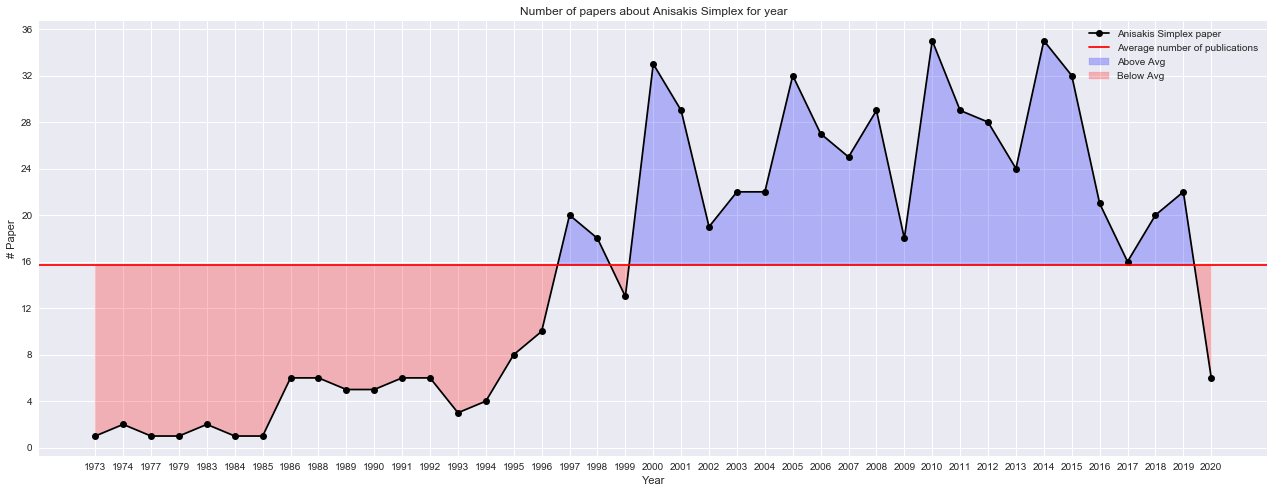

In [24]:
plot_num_per_date(summaries)

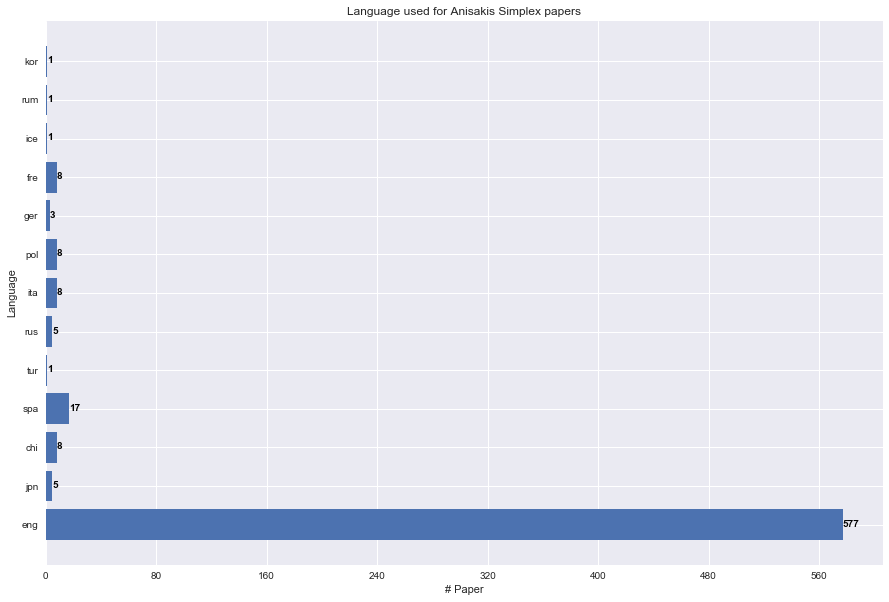

In [25]:
plot_lang(fetchs)

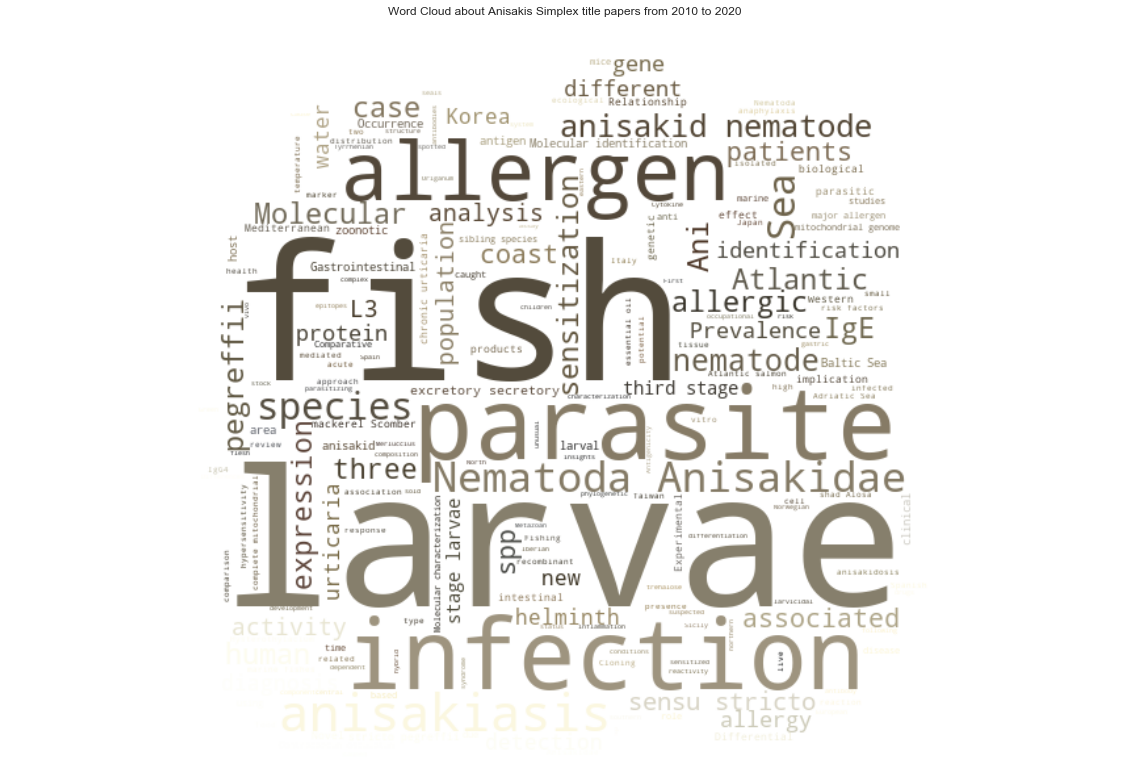

In [26]:
title_word_cloud(summaries, [2010, 2020])

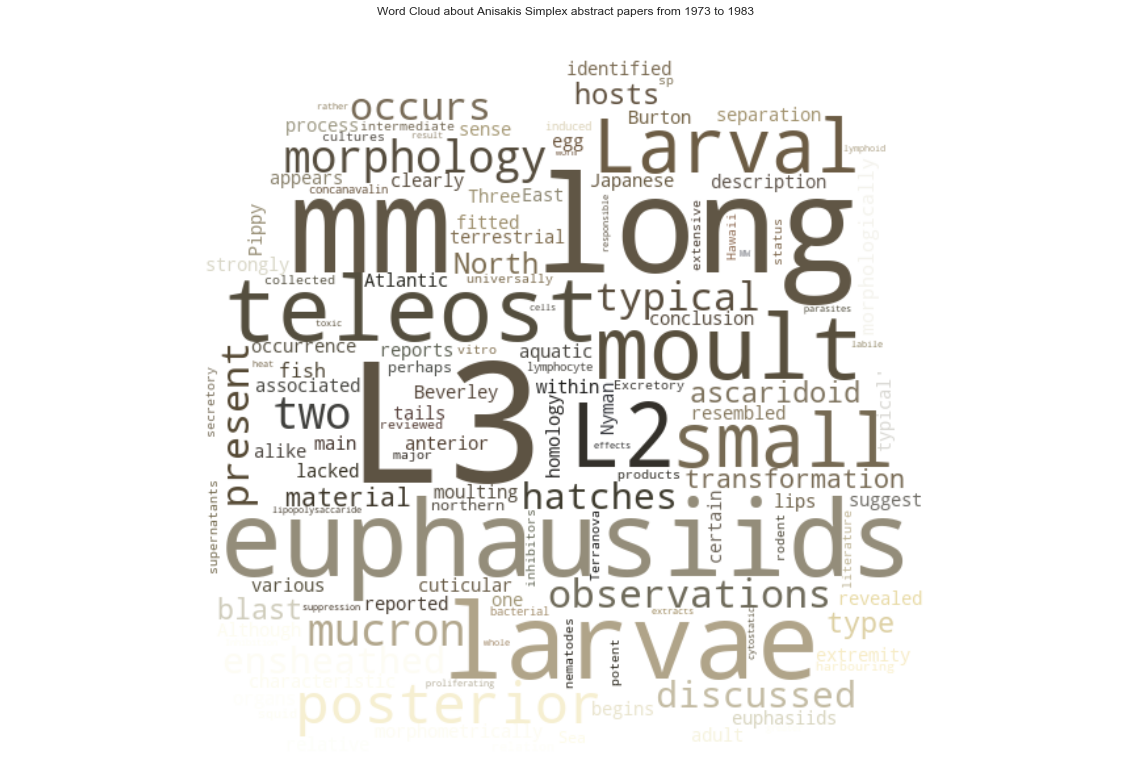

In [27]:
abstract_word_cloud(fetchs, [1973, 1983])

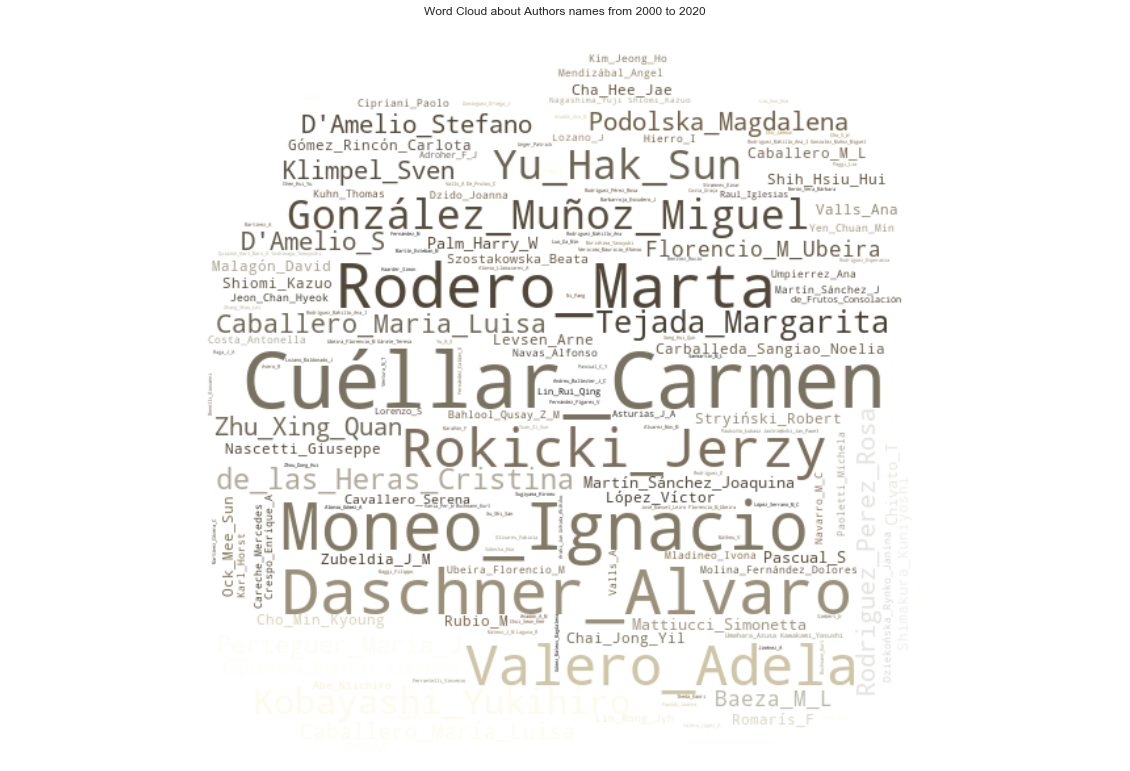

In [28]:
author_word_cloud(fetchs, [2000, 2020])

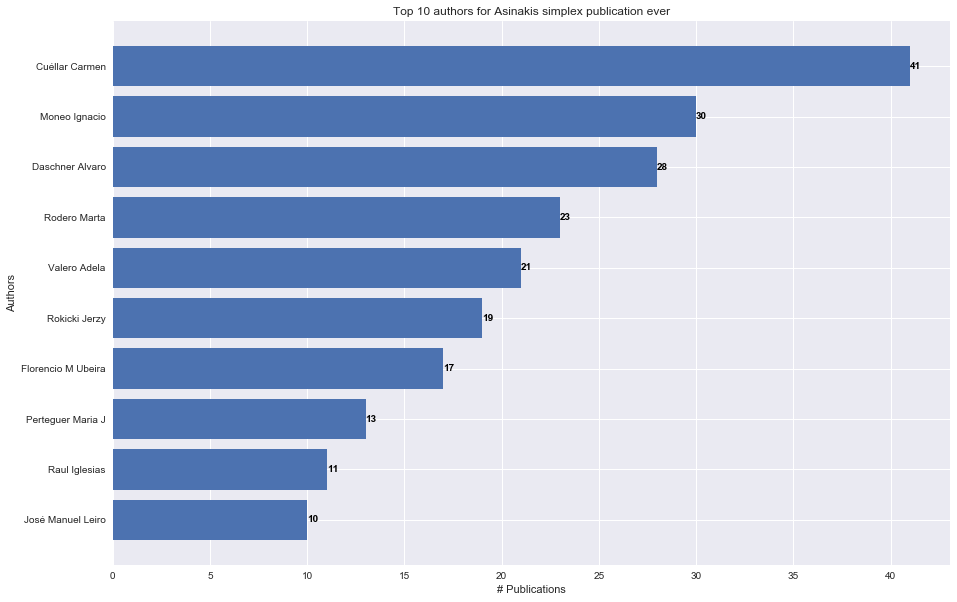

In [29]:
top_10_authors(fetchs, [])

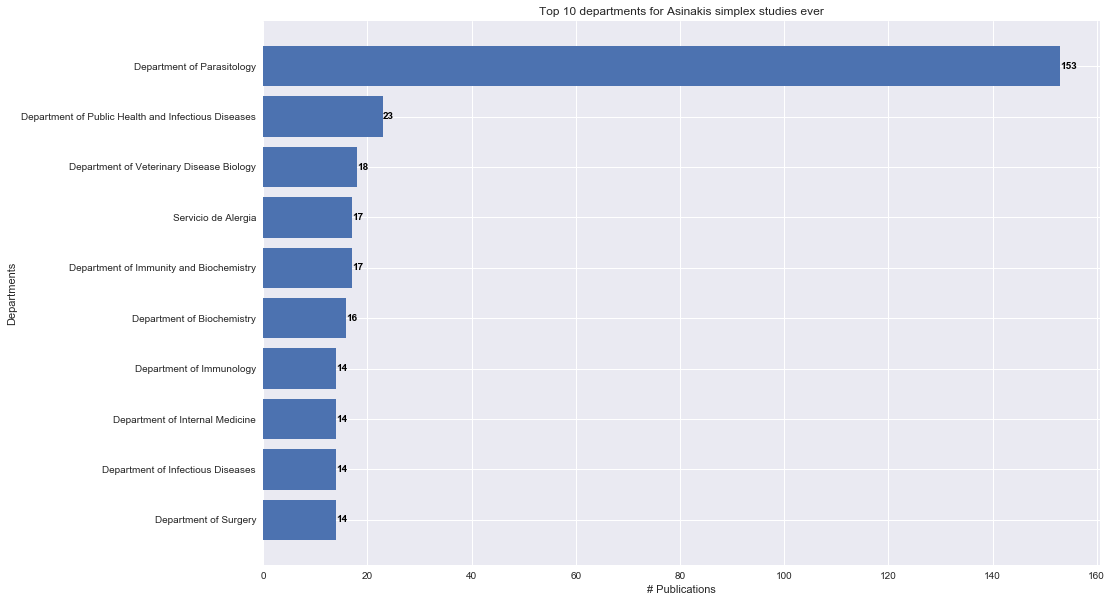

In [54]:
top_10_dpt(fetchs, [])

In [70]:
fetchs[56]['PubmedArticle'][0]['MedlineCitation']['Article']['AuthorList'][0]['AffiliationInfo'][0]['Affiliation'].split(',')[-1]

' Korea.'

In [157]:
def get_country(author, countries):
    try:
        country = author['AffiliationInfo'][0]['Affiliation'].split(',')[-1]
        country = country.split('.')[0]
        country = country.strip()
        country = country.split()[0]
        country = country.split(';')[0]
        
        if country == 'Korea' or country == 'Republic':
            country = 'South Korea'
        if country == 'Maryland' or country == 'USA' or country == 'Alabama' or country == 'Hawaii':
            country = 'United States of America'
        if (country == 'Nippon' or country == 'Kouseikai Takeda Hospital' or country == 'Tokyo' 
                            or country == 'Mito Saiseikai General Hospital' or country == 'Yokohama' 
                                or country == 'Fujita' or country == 'Shizuoka'):
            country = 'Japan'
        if (country == 'ROC' or country == 'España' or country == '28040' or country == 'Servicio' 
                        or country == 'Hospital' or country == 'Universidad'):
            country = 'Spain'
        print(country)
        if contry == 'PR' or country == 'Taiwan' or country == "People's":
            country = 'China'
        
        if country == 'Siena' or country == 'Dipartimento':
            country = 'Italy'
        
        if country == 'The':
            country = 'Netherlands'
        if country == '10-561' or country == 'Olsztyn':
            country = 'Poland'
        if country == 'Glasgow':
            country = 'UK'
        if country == 'Berlin':
            country  = 'Germany'
        
        if country in countries:
            countries[country] += 1
        else:
            countries[country] = 1
        
    except:
        pass
    
    return countries

In [158]:
def get_dpt_country(fetchs, years):
    countries = dict()
    cont = 0

    for fetch in fetchs:
        if years != []:
            if years[0] > years[1]:
                print('BAD YEARS INTERVALL')
                # return -1
            if int(summaries[cont][0]['PubDate'].split()[0]) >= years[0] and int(summaries[cont][0]['PubDate'].split()[0]) <= years[1]:
                authorList = fetch['PubmedArticle'][0]['MedlineCitation']['Article']['AuthorList']
                for author in authorList:
                    countries = get_country(author, countries)
        else:
            authorList = fetch['PubmedArticle'][0]['MedlineCitation']['Article']['AuthorList']
            for author in authorList:
                countries = get_country(author, countries)
        cont += 1
    return countries


In [159]:
countries = get_dpt_country(fetchs, years)

Poland
Poland
Poland
Poland
Poland
Poland
Spain
Spain
Spain
Spain
Italy
Italy
Italy
Italy
UK
Italy
Spain
Spain
Spain
Spain
Spain
Spain
Spain
Spain
Spain
Spain
Spain
Scotland
Scotland
Scotland
Scotland
Scotland
Poland
Poland
Poland
Poland
Poland
Poland
Poland
Poland
Poland
Poland
Poland
China
China
China
China
China
China
China
China
China
China
China
Poland
Poland
Poland
Poland
Poland
Poland
Australia
Australia
Australia
Spain
Czech
Spain
Spain
Italy
Italy
Italy
Italy
Italy
Italy
Italy
Italy
Italy
Italy
Japan
Japan
Japan
Japan
Spain
Spain
Spain
Spain
Spain
Italy
Italy
Italy
New
Argentina
Norway
Norway
Italy
Taiwan
Taiwan
Taiwan
Taiwan
Taiwan
Slovak
Slovak
Taiwan
Belgium
Cuba
Belgium
Belgium
The
Belgium
South Korea
South Korea
South Korea
South Korea
South Korea
South Korea
Poland
Poland
Poland
Poland
Poland
Poland
Italy
Italy
Italy
UK
UK
Spain
Spain
Spain
Spain
Poland
Spain
Spain
Spain
Spain
Poland
Spain
Spain
Japan
Japan
Japan
Japan
Poland
Poland
Poland
Poland
Poland
Poland
Poland
Pol

In [138]:
countries


{'South Korea': 57, 'United States of America': 34, 'Japan': 14, 'Spain': 28}

In [46]:
dpts_names

['Department of Surgery',
 'Department of Infectious Diseases',
 'Department of Internal Medicine',
 'Department of Immunology',
 'Department of Biochemistry',
 'Department of Immunity and Biochemistry',
 'Servicio de Alergia',
 'Department of Veterinary Disease Biology',
 'Department of Public Health and Infectious Diseases',
 'Department of Parasitology']

In [41]:
dpts_value

[14, 14, 14, 14, 16, 17, 17, 18, 23, 139]

In [32]:
dpts

{'Department of Biochemistry': 16,
 'Department of Fisheries Resources': 3,
 'Allergy Service': 6,
 'Laboratory of Parasitology and Allergy': 3,
 'Department of Public Health and Infectious Diseases': 23,
 'Department of Biology': 5,
 'Department of Veterinary Medicine': 13,
 'Marine Zoology Unit': 8,
 'Spanish Institute of Oceanography': 3,
 'CEMMA (Coordinadora para o Estudo dos Mamiferos Mariños)': 2,
 'School of Applied Sciences': 5,
 'Department of Biology and Medical Parasitology': 1,
 'Department of Tropical Parasitology': 2,
 'Department of Hydrobiology': 1,
 'Department of Surgery': 14,
 'Department of Plant Physiology': 7,
 'Department of Botany and Nature Protection': 2,
 'Department of Immunity and Biochemistry': 17,
 'Anhui Institute of Schistosomiasis': 2,
 'National Marine Fisheries Research Institute': 10,
 'Institute of Marine and Tropical Medicine in Gdynia': 1,
 'A&A Biotechnology': 2,
 'School of Science': 2,
 'Molecular Allergy Research Laboratory': 1,
 'Department

#### Possible analysis
* Summary
    * Source field (what is it?)
    * **PubDate (counting in function of the date)** ----- Needed more reasonable motivation about peaks
    * **LangList (language of paper)** ----- Why so much in Spain? Word cloud Paper ita
    * **Word cloud title (take in account the date in the case)**
    * **Time passed beetween received and entrez (history field)** --> Results aren't good
    * FullJournalName counting? (name of the journal where the paper has been publicated)
* Fetch
    * **Abstract world cloud**
    * **AuthorList --> AffiliationInfo --> Affiliation --> #Dpt of Uni, Plot nums of uni where working are based (basically counting in function of DPT and** whatch about University country) 
    * **Word cloud on Last name about authors (who is the most important one?)**, **counting about top 10** --> adjusts authors name
    * PublicationTypeList counting? (counting if is a Journal Article or other) 
    * MedlineJournalInfo --> Country --> Country per paper
    * Publisher who have published more
  
Leg:
**Done** 
, todo